In [ ]:
# Additional cell/
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import os
import json
from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
cudnn.benchmark = True  # fire on all cylinders
from sklearn.metrics import roc_auc_score, roc_curve
import sys
from tqdm import tqdm

In [ ]:
!pip install matplotlib==3.2.1 numpy==1.19.1 scikit-learn==0.23.1 tqdm==4.62.3 torch==1.11.0 torchvision==0.12.0 vit_pytorch==0.35.5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Additional cell
import importlib.util
import sys

spec2 = importlib.util.spec_from_file_location("wrn", "/content/drive/MyDrive/trojan_detection/tdc-starter-kit-main/wrn.py")
wrn = importlib.util.module_from_spec(spec2)
sys.modules["wrn"] = wrn
spec2.loader.exec_module(wrn)

spec = importlib.util.spec_from_file_location("utils", "/content/drive/MyDrive/trojan_detection/tdc-starter-kit-main/utils.py")
utils = importlib.util.module_from_spec(spec)
sys.modules["utils"] = utils
spec.loader.exec_module(utils)

In [ ]:
import json

models = set()
datasets = set()
for id in range(100, 500):
  name = "id-0" + str(id)
  path = '/content/drive/MyDrive/trojan_detection/tdc_datasets/trigger_synthesis/train/' + name + '/model.pt'
  json_path = '/content/drive/MyDrive/trojan_detection/tdc_datasets/trigger_synthesis/train/' + name + '/info.json'
  with open(json_path) as f:
    info = json.load(f)
  model = torch.load(path).cuda()
  # target_layers = []
  dataset = info['dataset']
  model_type = model.__class__.__name__
  if model_type not in models or dataset not in datasets:
    print(id, model_type, dataset, info['trigger_type'])
    models.add(model_type)
    datasets.add(dataset)
  # break

100 WideResNet CIFAR-10 patch
125 WideResNet CIFAR-100 patch
250 SimpleViT GTSRB patch
375 MNIST_Network MNIST patch


In [ ]:
# get training and testing datasets
transform = transforms.ToTensor()
training_data = {}
testing_data = {}
train_loader = {}
test_loader = {}
trigger_shape = {'MNIST': (1,28,28), 'CIFAR-10': (3,32,32), 'CIFAR-100': (3,32,32), 'GTSRB': (3,64,64)}
mask_shape = {'MNIST': (28,28), 'CIFAR-10': (32,32), 'CIFAR-100': (32,32), 'GTSRB': (32,32)}
classes = {'MNIST': 10, 'CIFAR-10': 10, 'CIFAR-100': 100, 'GTSRB': 43}

training_data['MNIST'] = torchvision.datasets.MNIST(root='./data/mnist', train=True,
                                        download=True, transform=transform)
testing_data['MNIST'] = torchvision.datasets.MNIST(root='./data/mnist', train=False,
                                       download=True, transform=transform)
train_loader['MNIST'] = torch.utils.data.DataLoader(training_data['MNIST'], 64)
test_loader['MNIST'] = torch.utils.data.DataLoader(testing_data['MNIST'], 64)

training_data['CIFAR-10'] = torchvision.datasets.CIFAR10(root='./data/cifar10', train=True,
                                        download=True, transform=transform)
testing_data['CIFAR-10'] = torchvision.datasets.CIFAR10(root='./data/cifar10', train=False,
                                       download=True, transform=transform)
train_loader['CIFAR-10'] = torch.utils.data.DataLoader(training_data['CIFAR-10'], 64)
test_loader['CIFAR-10'] = torch.utils.data.DataLoader(testing_data['CIFAR-10'], 64)

training_data['CIFAR-100'] = torchvision.datasets.CIFAR100(root='./data/cifar100', train=True,
                                        download=True, transform=transform)
testing_data['CIFAR-100'] = torchvision.datasets.CIFAR100(root='./data/cifar100', train=False,
                                       download=True, transform=transform)
train_loader['CIFAR-100'] = torch.utils.data.DataLoader(training_data['CIFAR-100'], 64)
test_loader['CIFAR-100'] = torch.utils.data.DataLoader(testing_data['CIFAR-100'], 64)

# transform = [transforms.ToTensor(), transforms.Resize()]
training_data['GTSRB'] = torchvision.datasets.GTSRB(root='./data/gtsrb', split="train",
                                        download=True, transform=transforms.Compose(
                                           [transforms.Resize((64, 64)), transforms.ToTensor()]))
testing_data['GTSRB'] = torchvision.datasets.GTSRB(root='./data/gtsrb', split="test",
                                       download=True, transform=transforms.Compose(
                                           [transforms.Resize((32, 32)), transforms.ToTensor()]))
train_loader['GTSRB'] = torch.utils.data.DataLoader(training_data['GTSRB'], 64)
test_loader['GTSRB'] = torch.utils.data.DataLoader(testing_data['GTSRB'], 64)


Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 64, 64])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matricesor `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2318.)
  


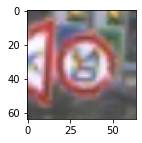

In [ ]:
plt.figure(figsize=(2,2))
plt.imshow(training_data['GTSRB'][0][0].T)
print(training_data['GTSRB'][0][0].shape)

In [ ]:
def apply_trigger(x, trigger, mask):
  xprime = (1 - mask) * x + mask * trigger
  return xprime

In [ ]:
def objective(outputs, labels, mask, reg=0.01):
  loss = nn.CrossEntropyLoss()
  total = loss(outputs, labels) + reg * torch.norm(mask, 1)
  return total

In [ ]:
import torch.optim as optim

name = "id-0375"
path = '/content/drive/MyDrive/trojan_detection/tdc_datasets/trigger_synthesis/train/' + name + '/model.pt'
json_path = '/content/drive/MyDrive/trojan_detection/tdc_datasets/trigger_synthesis/train/' + name + '/info.json'
with open(json_path) as f:
  info = json.load(f)
dataset = info['dataset']
model = torch.load(path).cuda()
trigger = torch.rand(trigger_shape[dataset], requires_grad = True, device="cuda")
mask = torch.rand(mask_shape[dataset], requires_grad = True, device="cuda")
optimizer = optim.Adam([mask, trigger], lr=0.001)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
target_label = 8

for epoch in range(2):
  for i, data in enumerate(train_loader[dataset], 0):
    inputs, labels = data
    indices = labels != target_label
    inputs = inputs[indices]
    labels = labels[indices]
    labels[:] = target_label
    inputs, labels = inputs.to(device), labels.to(device)
    inputs *= 255
    # print(inputs.shape, labels.shape)
    optimizer.zero_grad()
    new_images = apply_trigger(inputs, trigger, mask)
    outputs = model(new_images)
    loss = objective(outputs, labels, mask, 10)
    loss.backward()
    optimizer.step()
    if i % 500 == 0:
      print(f"Obj func {loss.item()}, Cross Entropy {nn.CrossEntropyLoss()(outputs, labels).item()}, L1 norm of mask {torch.norm(mask, 1).item()}")

Obj func 4409.07763671875, Cross Entropy 503.0959777832031, L1 norm of mask 389.9454345703125
Obj func 1920.79931640625, Cross Entropy 388.34710693359375, L1 norm of mask 152.92691040039062
Obj func 955.1114501953125, Cross Entropy 265.9009094238281, L1 norm of mask 68.8648681640625
Obj func 914.4239501953125, Cross Entropy 297.7686462402344, L1 norm of mask 61.668914794921875


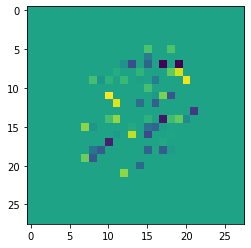

In [ ]:
# plt.figure(figsize=(8,8))
plt.imshow((mask*trigger).cpu().detach().numpy().squeeze())

5


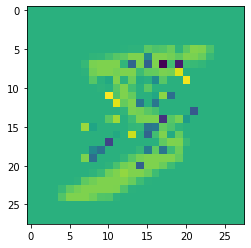

In [ ]:
images5 = []
for images, labels in train_loader[dataset]:
  indices = labels == 5
  newims = images[indices]
  # print(newims.shape, labels[indices].shape)
  for i in newims:
    # plt.imshow(i.squeeze())
    i = i.cuda()
    iprime = apply_trigger(i, trigger, mask)
    iprimeimage = iprime.clone()
    plt.imshow(iprimeimage.cpu().detach().numpy().squeeze())
    print(torch.argmax(model(iprime.unsqueeze(0)), 1).item())
    if torch.argmax(model(iprime.unsqueeze(0)), 1).item() != 5:
      print("trojaned")
    break
    #print("hello")
  break

In [ ]:
# import torch.optim as optim

path = '/content/drive/MyDrive/trojan_detection/tdc_datasets/trigger_synthesis/train/id-0375/model.pt'
model = torch.load(path).cuda()
list_triggers = []
list_masks = []
for target_label in range(10):
  trigger = torch.rand(trigger_shape['MNIST'], requires_grad = True, device="cuda")
  mask = torch.rand(mask_shape['MNIST'], requires_grad = True, device="cuda")
  optimizer = optim.Adam([mask, trigger], lr=0.01)
  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  print("Target Label ", target_label)

  for epoch in range(2):
    for i, data in enumerate(train_loader['MNIST'], 0):
      inputs, labels = data
      indices = labels != target_label
      inputs = inputs[indices]
      labels = labels[indices]
      labels[:] = target_label
      inputs, labels = inputs.to(device), labels.to(device)
      inputs = torch.rand((inputs.shape)).to(device)
      # print(inputs.shape, labels.shape)
      optimizer.zero_grad()
      new_images = apply_trigger(inputs, trigger, F.relu(mask))
      outputs = model(new_images)
      loss = objective(outputs, labels, mask,1)
      loss.backward()
      optimizer.step()
      if i % 500 == 0:
        print(f"Obj func {loss.item()}, Cross Entropy {nn.CrossEntropyLoss()(outputs, labels).item()}, L1 norm of mask {torch.norm(mask, 1)}")
      # print(images.shape, labels.shape)

  list_triggers.append(trigger)
  list_masks.append(mask)

  for images, labels in train_loader['MNIST']:
    for l in range(10):
      if l == target_label:
        continue
      indices = labels == l
      newims = images[indices]
    # print(newims.shape, labels[indices].shape)
      for i in newims:
      # plt.imshow(i.squeeze())
        i = i.cuda()
        iprime = apply_trigger(i, trigger, F.relu(mask))
        iprimeimage = iprime.clone()
      # plt.imshow(iprimeimage.cpu().detach().numpy().squeeze())
        if torch.argmax(model(iprime.unsqueeze(0)), 1).item() == target_label:
          print(f"Trojaned!, true label {l}, target label {target_label}")
        break
    break

Target Label  0
Obj func 410.40472412109375, Cross Entropy 13.805096626281738, L1 norm of mask 388.8497009277344
Obj func 16.900264739990234, Cross Entropy 15.676548957824707, L1 norm of mask 1.222107172012329
Obj func 7.610479354858398, Cross Entropy 2.5752546787261963, L1 norm of mask 5.044766426086426
Obj func 5.181863784790039, Cross Entropy 0.3963761627674103, L1 norm of mask 4.78483772277832
Trojaned!, true label 1, target label 0
Trojaned!, true label 3, target label 0
Trojaned!, true label 5, target label 0
Trojaned!, true label 7, target label 0
Trojaned!, true label 8, target label 0
Trojaned!, true label 9, target label 0
Target Label  1
Obj func 396.7765808105469, Cross Entropy 15.121222496032715, L1 norm of mask 373.914306640625
Obj func 16.579362869262695, Cross Entropy 14.786030769348145, L1 norm of mask 1.8452588319778442
Obj func 3.7019567489624023, Cross Entropy 0.20317186415195465, L1 norm of mask 3.5106024742126465
Obj func 3.0164260864257812, Cross Entropy 0.081006

-17.01810646057129 21.88494873046875
-13.646651268005371 7.321025371551514
-11.824531555175781 14.635400772094727
-17.386348724365234 10.550232887268066
-9.253594398498535 21.028072357177734
-19.90450668334961 23.89109230041504
-15.936820030212402 13.307827949523926
-17.065052032470703 16.02253532409668
-8.65728759765625 10.327078819274902
-17.525287628173828 17.99349021911621


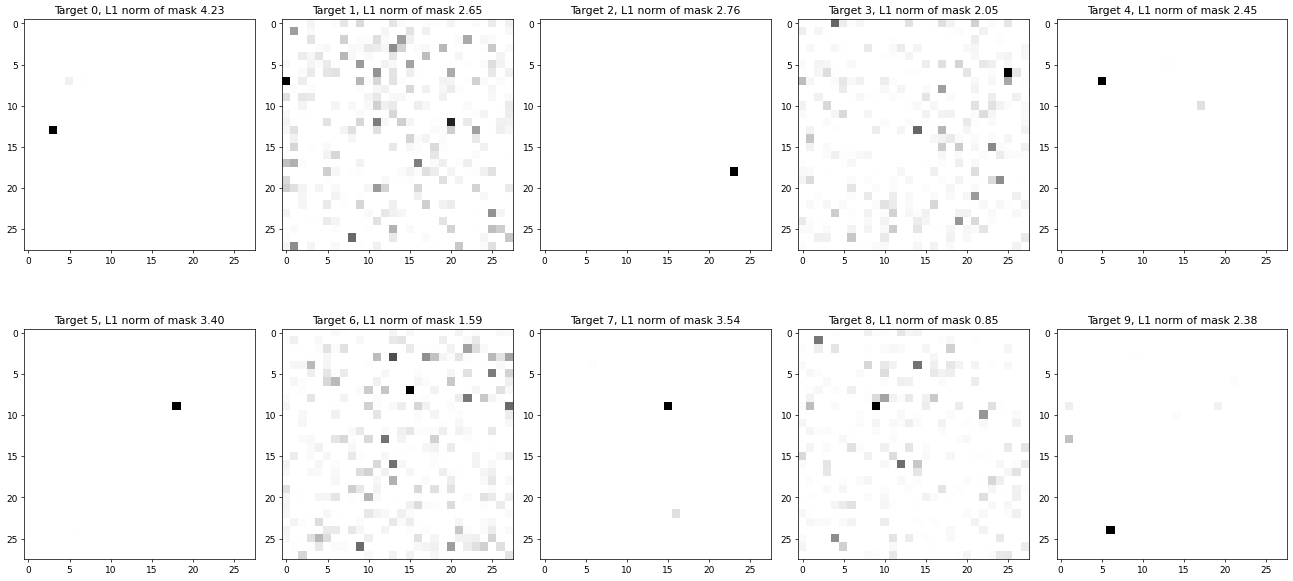

In [ ]:
f = plt.figure(figsize=(20,10), dpi=65)
f.set_label("Triggers")
for i in range(len(list_masks)):
  ax = f.add_subplot(2, 5, i+1)
  print(torch.min(list_triggers[i]).item(), torch.max(list_triggers[i]).item())
  im = ax.imshow((F.relu(list_masks[i])*F.relu(list_triggers[i])).cpu().detach().numpy().squeeze(), cmap='Greys')
  ax.set_title(f"Target {i}, L1 norm of mask {torch.norm(list_masks[i], 1):.2f}")
  # break
f.tight_layout(h_pad=1)
# plt.colorbar(im)

0.0 1.0


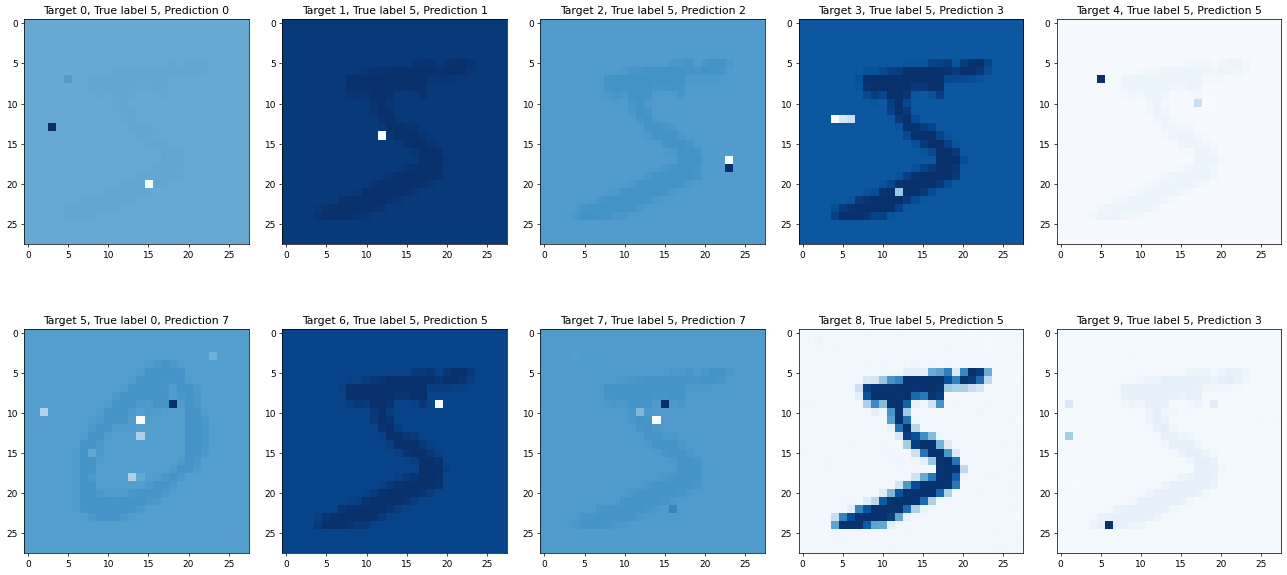

In [ ]:
# for data in train_loader:
image = training_data['MNIST'][0][0]
f = plt.figure(figsize=(20,10), dpi=65)
f.set_label("Triggers applied to image")
for i in range(len(list_masks)):
  ax = f.add_subplot(2, 5, i+1)
  # print(torch.min(list_masks[i]*list_triggers[i]).item(), torch.max(list_masks[i]*list_triggers[i]).item())
  output = apply_trigger(image.to(device), list_triggers[i], F.relu(list_masks[i]))
  if i == 5:
    output = apply_trigger(training_data['MNIST'][1][0].to(device), list_triggers[i], F.relu(list_masks[i]))
    im = ax.imshow(output.cpu().detach().squeeze(), cmap='Blues')
    ax.set_title(f"Target {i}, True label {0}, Prediction {torch.argmax(model(output.unsqueeze(0)), 1).item()}")
    continue
  im = ax.imshow(output.cpu().detach().squeeze(), cmap='Blues')
  ax.set_title(f"Target {i}, True label {5}, Prediction {torch.argmax(model(output.unsqueeze(0)), 1).item()}")
f.tight_layout(h_pad=1)
print(torch.min(training_data['MNIST'][1][0]).item(), torch.max(training_data['MNIST'][1][0]).item())

Text(0.5, 1.0, 'Raw image of 5')

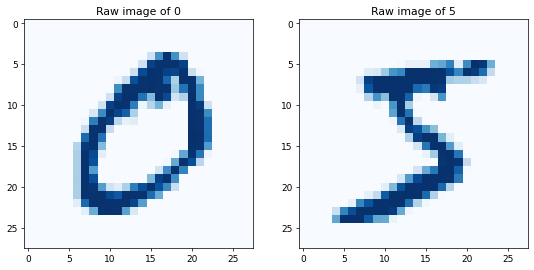

In [ ]:
f = plt.figure(figsize=(10,5), dpi=65)
ax = plt.subplot(1,2, 1)
ax.imshow(training_data['MNIST'][1][0].squeeze(), cmap = 'Blues')
ax.set_title('Raw image of 0')
ax = plt.subplot(1,2, 2)
ax.imshow(training_data['MNIST'][0][0].squeeze(), cmap='Blues')
ax.set_title('Raw image of 5')

In [ ]:
path = '/content/drive/MyDrive/trojan_detection/tdc_datasets/trigger_synthesis/train/id-0375/model.pt'
attack_path = '/content/drive/MyDrive/trojan_detection/tdc_datasets/trigger_synthesis/train/id-0375/attack_specification.pt'
model = torch.load(path).cuda()
attack = torch.load(path).cuda()
